# Setup

Requires Python 3.10 and Poetry 1.6. Run setup commands to begin:
```
!poetry install
!poetry run jupyter lab
```

Load libraries and set parameters

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_columns = None

Load raw data

In [3]:
data_path = "data"
raw_data = {
    "A": {
        "test_est": pd.read_parquet(os.path.join(data_path, "A", "X_test_estimated.parquet")),
        "train_est": pd.read_parquet(os.path.join(data_path, "A", "X_train_estimated.parquet")),
        "train_obs": pd.read_parquet(os.path.join(data_path, "A", "X_train_observed.parquet")),
        "train_tar": pd.read_parquet(os.path.join(data_path, "A", "train_targets.parquet")),
    },
    "B": {
        "test_est": pd.read_parquet(os.path.join(data_path, "B", "X_test_estimated.parquet")),
        "train_est": pd.read_parquet(os.path.join(data_path, "B", "X_train_estimated.parquet")),
        "train_obs": pd.read_parquet(os.path.join(data_path, "B", "X_train_observed.parquet")),
        "train_tar": pd.read_parquet(os.path.join(data_path, "B", "train_targets.parquet")),
    },
    "C": {
        "test_est": pd.read_parquet(os.path.join(data_path, "C", "X_test_estimated.parquet")),
        "train_est": pd.read_parquet(os.path.join(data_path, "C", "X_train_estimated.parquet")),
        "train_obs": pd.read_parquet(os.path.join(data_path, "C", "X_train_observed.parquet")),
        "train_tar": pd.read_parquet(os.path.join(data_path, "C", "train_targets.parquet")),
    },
}

View data

In [3]:
raw_data["C"]["test_est"]

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2023-04-30 07:00:04,2023-05-01 00:00:00,4.2,1.286,NaN,0.0,0.0,1178.000000,0.0,271.100006,0.0,0.0,0.0,0.0,73.699997,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1014.000000,0.0,0.0,998.200012,1004.500000,0.0,0.0,81.099998,1010.799988,NaN,0.0,0.0,0.0,0.0,10.519000,-11.223,0.0,273.700012,73.699997,31411.000000,3.5,1.5,3.1,-0.0
1,2023-04-30 07:00:04,2023-05-01 00:15:00,4.2,1.286,NaN,0.0,0.0,1217.000000,0.0,271.100006,0.0,0.0,0.0,0.0,70.800003,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.799988,0.0,0.0,998.099976,1004.299988,0.0,0.0,81.000000,1010.599976,NaN,0.0,0.0,0.0,0.0,14.202000,-10.862,0.0,273.700012,70.800003,31295.800781,3.4,1.5,3.1,-0.0
2,2023-04-30 07:00:04,2023-05-01 00:30:00,4.1,1.286,NaN,0.0,0.0,1256.000000,0.0,271.000000,0.0,0.0,0.0,0.0,67.900002,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.700012,0.0,0.0,998.000000,1004.200012,0.0,0.0,80.900002,1010.500000,NaN,0.0,0.0,0.0,0.0,17.868000,-10.397,0.0,273.700012,67.900002,31178.599609,3.4,1.4,3.1,-0.0
3,2023-04-30 07:00:04,2023-05-01 00:45:00,4.1,1.286,NaN,0.0,0.0,1295.000000,0.0,270.899994,0.0,0.0,0.0,0.0,64.800003,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.599976,0.0,0.0,997.799988,1004.099976,0.0,0.0,80.800003,1010.400024,NaN,0.0,0.0,0.0,0.0,21.513000,-9.830,0.0,273.700012,64.800003,31082.500000,3.4,1.4,3.1,-0.0
4,2023-04-30 07:00:04,2023-05-01 01:00:00,4.1,1.286,NaN,0.0,0.0,1334.099976,0.0,270.899994,0.0,0.0,0.0,0.0,61.599998,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.400024,0.0,0.0,997.700012,1004.000000,0.0,0.0,80.599998,1010.299988,NaN,0.0,0.0,0.0,0.0,25.134001,-9.163,0.0,273.700012,61.599998,31051.400391,3.4,1.4,3.1,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2023-07-02 07:00:31,2023-07-03 22:45:00,9.0,1.207,2003.500000,0.0,0.0,1573.000000,0.0,282.600006,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.400024,0.0,0.0,978.799988,984.700012,0.0,0.0,84.000000,990.599976,NaN,0.0,0.0,-0.0,0.0,351.852997,-3.320,0.1,285.299988,100.000000,39008.300781,1.8,1.6,-0.7,0.0
2876,2023-07-02 07:00:31,2023-07-03 23:00:00,9.0,1.207,2005.599976,0.0,0.0,1471.000000,0.0,282.500000,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.500000,0.0,0.0,978.799988,984.700012,0.0,0.0,84.099998,990.700012,NaN,0.0,0.0,-0.0,0.0,355.315002,-3.508,0.1,285.200012,100.000000,39026.000000,1.7,1.6,-0.7,0.0
2877,2023-07-02 07:00:31,2023-07-03 23:15:00,9.0,1.207,2005.500000,0.0,0.0,1346.900024,0.0,282.500000,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.500000,0.0,0.0,978.900024,984.799988,0.0,0.0,84.400002,990.700012,NaN,0.0,0.0,-0.0,0.0,358.782013,-3.594,0.1,285.100006,100.000000,39081.300781,1.7,1.6,-0.6,0.0
2878,2023-07-02 07:00:31,2023-07-03 23:30:00,8.9,1.207,2005.500000,0.0,0.0,1222.800049,0.0,282.500000,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.599976,0.0,0.0,979.000000,984.900024,0.0,0.0,84.800003,990.799988,NaN,0.0,0.0,-0.0,0.0,2.250000,-3.579,0.2,285.100006,100.000000,39145.101562,1.7,1.6,-0.6,0.0


In [4]:
raw_data["C"]["train_est"]

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2022-10-27 07:00:18,2022-10-28 22:00:00,8.3,1.231,1427.400024,0.0,0.0,1215.800049,1.0,281.200012,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1001.099976,0.0,0.0,986.000000,992.000000,0.0,0.0,93.900002,998.099976,NaN,0.0,0.0,-0.0,0.4,340.785004,-38.502998,0.0,285.200012,100.000000,34387.398438,1.2,-0.3,1.1,-0.0
1,2022-10-27 07:00:18,2022-10-28 22:15:00,8.3,1.231,2089.000000,0.0,0.0,1425.900024,1.0,281.200012,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1000.700012,0.0,0.0,985.700012,991.700012,0.0,0.0,93.599998,997.700012,NaN,0.0,0.0,-0.0,0.5,345.440002,-38.992001,0.0,285.100006,100.000000,27418.500000,1.2,-0.2,1.2,-0.0
2,2022-10-27 07:00:18,2022-10-28 22:30:00,8.3,1.231,2750.500000,0.0,0.0,1636.099976,1.0,281.100006,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1000.400024,0.0,0.0,985.400024,991.400024,0.0,0.1,93.300003,997.400024,NaN,0.0,0.0,-0.0,0.5,350.144012,-39.348000,0.0,285.100006,100.000000,20508.800781,1.2,-0.1,1.2,-0.0
3,2022-10-27 07:00:18,2022-10-28 22:45:00,8.2,1.230,3412.100098,0.0,0.0,1846.199951,1.0,281.100006,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1000.099976,0.0,0.0,985.099976,991.099976,0.0,0.1,93.000000,997.099976,NaN,0.0,0.0,-0.0,0.5,354.880005,-39.567001,0.0,285.000000,100.000000,13657.799805,1.2,-0.0,1.2,-0.0
4,2022-10-27 07:00:18,2022-10-28 23:00:00,8.2,1.230,4073.699951,0.0,0.0,2056.399902,1.0,281.100006,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,999.700012,0.0,0.0,984.700012,990.700012,0.0,0.1,92.699997,996.799988,NaN,0.0,0.0,-0.0,0.6,359.634003,-39.647999,0.0,285.000000,100.000000,6865.000000,1.2,0.1,1.2,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17571,2023-04-29 07:00:05,2023-04-30 22:45:00,4.4,1.280,1034.599976,0.0,0.0,562.299988,0.0,272.000000,0.0,0.0,0.0,0.0,99.800003,24.0,0.0,0.0,0.4,0.0,0.0,0.0,1.0,1014.400024,0.0,0.0,998.599976,1004.900024,0.0,0.0,80.000000,1011.099976,NaN,0.0,0.0,-0.0,0.1,352.915985,-11.769000,0.2,274.200012,99.900002,10681.200195,3.0,2.1,2.2,-0.0
17572,2023-04-29 07:00:05,2023-04-30 23:00:00,4.4,1.280,897.200012,0.0,0.0,569.500000,0.0,272.000000,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1014.400024,0.0,0.0,998.500000,1004.799988,0.0,0.0,80.400002,1011.099976,NaN,0.0,0.0,-0.0,0.1,356.630005,-11.923000,0.2,274.100006,100.000000,9890.900391,2.8,1.9,2.1,-0.0
17573,2023-04-29 07:00:05,2023-04-30 23:15:00,4.4,1.280,1288.699951,0.0,0.0,562.299988,0.0,272.000000,0.0,0.0,0.0,0.0,99.699997,24.0,0.0,0.0,0.4,0.0,0.0,0.0,1.0,1014.200012,0.0,0.0,998.400024,1004.700012,0.0,0.0,80.099998,1010.900024,NaN,0.0,0.0,-0.0,0.1,0.349000,-11.967000,0.1,274.200012,100.000000,10716.799805,2.9,1.9,2.2,-0.0
17574,2023-04-29 07:00:05,2023-04-30 23:30:00,4.4,1.280,1680.300049,0.0,0.0,555.099976,0.0,271.899994,0.0,0.0,0.0,0.0,99.000000,24.0,0.0,0.0,0.4,0.0,0.0,0.0,1.0,1014.099976,0.0,0.0,998.299988,1004.500000,0.0,0.0,79.800003,1010.799988,NaN,0.0,0.0,-0.0,0.1,4.067000,-11.902000,0.1,274.200012,99.800003,11538.799805,3.0,1.9,2.3,-0.0


In [5]:
raw_data["C"]["train_obs"]

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2019-01-01 00:00:00,5.6,1.240,1153.599976,0.0,0.0,1153.599976,1.0,275.200012,0.0,0.0,0.0,0.0,63.599998,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,987.299988,0.00,0.0,972.599976,978.599976,0.0,0.0,90.199997,984.700012,NaN,0.0,0.0,-0.0,0.0,12.989000,-49.178001,0.0,278.500000,68.500000,18220.400391,2.5,1.1,2.2,-0.0
1,2019-01-01 00:15:00,5.5,1.241,1137.900024,0.0,0.0,1137.900024,1.0,275.100006,0.0,0.0,0.0,0.0,74.900002,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,987.099976,0.06,1.0,972.299988,978.299988,0.2,0.0,90.000000,984.400024,NaN,0.0,0.0,-0.0,0.0,18.214001,-48.724998,0.0,278.399994,80.800003,17083.699219,2.8,1.1,2.5,-0.0
2,2019-01-01 00:30:00,5.4,1.241,1122.199951,0.0,0.0,1122.199951,1.0,274.899994,0.0,0.0,0.0,0.0,84.300003,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.799988,0.06,1.0,972.000000,978.000000,0.3,0.0,89.900002,984.099976,NaN,0.0,0.0,-0.0,0.1,23.351000,-48.127998,0.0,278.299988,89.900002,15940.900391,3.0,1.1,2.8,-0.0
3,2019-01-01 00:45:00,5.4,1.241,1106.400024,0.0,0.0,1106.400024,1.0,274.700012,0.0,0.0,0.0,0.0,92.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.599976,0.06,1.0,971.700012,977.799988,0.3,0.0,89.699997,983.799988,NaN,0.0,0.0,-0.0,0.1,28.382000,-47.393002,0.0,278.200012,96.099998,14792.000000,3.3,1.2,3.0,-0.0
4,2019-01-01 01:00:00,5.3,1.241,1090.599976,0.0,0.0,1090.599976,1.0,274.500000,0.0,0.0,0.0,0.0,98.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.400024,0.06,1.0,971.400024,977.500000,0.4,0.0,89.599998,983.599976,NaN,0.0,0.0,-0.0,0.1,33.292999,-46.529999,0.0,278.100006,99.400002,13637.299805,3.5,1.2,3.3,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116820,2022-05-01 21:00:00,4.9,1.257,2652.000000,0.0,0.0,1536.500000,0.0,273.600006,0.0,0.0,0.0,0.0,95.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1014.799988,0.00,0.0,999.299988,1005.400024,0.0,0.0,62.599998,1011.599976,NaN,0.0,0.0,-0.0,0.0,327.303009,-7.367000,0.0,279.299988,100.000000,38312.000000,4.7,3.0,3.6,-0.0
116821,2022-05-01 21:15:00,4.9,1.256,2375.300049,0.0,0.0,1484.500000,0.0,273.600006,0.0,0.0,0.0,0.0,97.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1014.500000,0.00,0.0,999.000000,1005.099976,0.0,0.0,62.799999,1011.299988,NaN,0.0,0.0,-0.0,0.0,330.863007,-8.232000,0.1,279.299988,100.000000,38344.199219,4.8,3.2,3.6,-0.0
116822,2022-05-01 21:30:00,4.9,1.256,2098.699951,0.0,0.0,1432.500000,0.0,273.500000,0.0,0.0,0.0,0.0,98.500000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1014.200012,0.00,0.0,998.599976,1004.799988,0.0,0.0,63.000000,1010.900024,NaN,0.0,0.0,-0.0,0.0,334.451996,-9.006000,0.1,279.200012,100.000000,38402.601562,4.9,3.3,3.6,-0.0
116823,2022-05-01 21:45:00,4.8,1.255,1822.000000,0.0,0.0,1380.400024,0.0,273.399994,0.0,0.0,0.0,0.0,99.500000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.900024,0.00,0.0,998.299988,1004.400024,0.0,0.0,63.200001,1010.599976,NaN,0.0,0.0,-0.0,0.0,338.067993,-9.683000,0.1,279.200012,100.000000,38478.800781,5.0,3.5,3.6,-0.0


In [6]:
raw_data["C"]["train_tar"]

,time,pv_measurement
0,2018-12-31 23:00:00,NaN
1,2019-01-01 00:00:00,NaN
2,2019-01-01 01:00:00,NaN
3,2019-01-01 02:00:00,NaN
4,2019-01-01 03:00:00,NaN
...,...,...
32150,2023-04-30 19:00:00,50.96
32151,2023-04-30 20:00:00,2.94
32152,2023-04-30 21:00:00,0.00
32153,2023-04-30 22:00:00,-0.00


Preproccess data

In [4]:
# Create empty list of location train data and location test data
location_train_data = []
location_test_data = []

# Copy raw data dictonary and loop through it
raw_data_copy = raw_data.copy()
for k in raw_data_copy:

    # Add a column with the difference between date_forecast and date_calc in seconds and remove date_calc
    raw_data_copy[k]["train_obs"]["forecast_seconds"] = 0
    raw_data_copy[k]["train_est"]["forecast_seconds"] = (raw_data_copy[k]["train_est"]["date_forecast"] - raw_data_copy[k]["train_est"]["date_calc"]).apply(lambda x: x.total_seconds())
    del raw_data_copy[k]["train_est"]["date_calc"]
    raw_data_copy[k]["test_est"]["forecast_seconds"] = (raw_data_copy[k]["test_est"]["date_forecast"] - raw_data_copy[k]["test_est"]["date_calc"]).apply(lambda x: x.total_seconds())
    del raw_data_copy[k]["test_est"]["date_calc"]

    # Add a column with location
    raw_data_copy[k]["train_obs"]["location"] = k
    raw_data_copy[k]["train_est"]["location"] = k
    raw_data_copy[k]["test_est"]["location"] = k

    # Concat and merge train observed, train estimated and train target to one dataframe and push to location_train_data list
    location_train_data.append(pd.merge(
        pd.concat([
            raw_data_copy[k]["train_obs"].rename(columns={"date_forecast": "time"}),
            raw_data_copy[k]["train_est"].rename(columns={"date_forecast": "time"}),
        ]),
        raw_data_copy[k]["train_tar"],
        on="time"
    ))

    # Push test estimate to location test data list
    location_test_data.append(raw_data_copy[k]["test_est"].rename(columns={"date_forecast": "time"}))

# Concat all the location data and sort by time
train_data = pd.concat(location_train_data).dropna(subset=["pv_measurement"]).reset_index()
test_data = pd.concat(location_test_data).reset_index()

# Replace all ':' with '_'
train_data.columns = [col_name.replace(":", "_") for col_name in train_data.columns]
test_data.columns = [col_name.replace(":", "_") for col_name in test_data.columns]

In [8]:
train_data

,index,time,absolute_humidity_2m_gm3,air_density_2m_kgm3,ceiling_height_agl_m,clear_sky_energy_1h_J,clear_sky_rad_W,cloud_base_agl_m,dew_or_rime_idx,dew_point_2m_K,diffuse_rad_W,diffuse_rad_1h_J,direct_rad_W,direct_rad_1h_J,effective_cloud_cover_p,elevation_m,fresh_snow_12h_cm,fresh_snow_1h_cm,fresh_snow_24h_cm,fresh_snow_3h_cm,fresh_snow_6h_cm,is_day_idx,is_in_shadow_idx,msl_pressure_hPa,precip_5min_mm,precip_type_5min_idx,pressure_100m_hPa,pressure_50m_hPa,prob_rime_p,rain_water_kgm2,relative_humidity_1000hPa_p,sfc_pressure_hPa,snow_density_kgm3,snow_depth_cm,snow_drift_idx,snow_melt_10min_mm,snow_water_kgm2,sun_azimuth_d,sun_elevation_d,super_cooled_liquid_water_kgm2,t_1000hPa_K,total_cloud_cover_p,visibility_m,wind_speed_10m_ms,wind_speed_u_10m_ms,wind_speed_v_10m_ms,wind_speed_w_1000hPa_ms,forecast_seconds,location,pv_measurement
0,0,2019-06-02 22:00:00,7.7,1.230,1744.900024,0.000000,0.0,1744.900024,0.0,280.299988,0.0,0.000000,0.0,0.000000,98.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.799988,0.0,0.0,994.200012,1000.299988,0.0,0.0,73.099998,1006.299988,NaN,0.0,0.0,-0.0,0.1,342.834015,-3.202,0.0,285.899994,100.000000,39640.101562,3.7,-3.6,-0.8,-0.0,0.0,A,0.00
1,1,2019-06-02 23:00:00,7.7,1.225,1703.599976,0.000000,0.0,1703.599976,0.0,280.299988,0.0,0.000000,0.0,0.000000,99.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.500000,0.0,0.0,993.000000,999.000000,0.0,0.0,69.199997,1005.000000,NaN,0.0,0.0,-0.0,0.2,356.742004,-4.393,0.0,286.799988,100.000000,41699.898438,3.5,-3.5,0.0,-0.0,0.0,A,0.00
2,2,2019-06-03 00:00:00,7.7,1.221,1668.099976,0.000000,0.0,1668.099976,0.0,280.200012,0.0,0.000000,0.0,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.599976,0.0,0.0,992.099976,998.099976,0.0,0.1,66.000000,1004.099976,NaN,0.0,0.0,-0.0,0.2,9.741000,-3.910,0.0,287.000000,100.000000,20473.000000,3.2,-3.1,0.7,-0.0,0.0,A,0.00
3,3,2019-06-03 01:00:00,8.2,1.218,1388.400024,0.000000,0.0,1388.400024,0.0,281.299988,0.0,0.000000,0.0,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.400024,0.0,0.0,991.799988,997.799988,0.0,0.2,71.099998,1003.799988,NaN,0.0,0.0,-0.0,0.7,23.541000,-1.986,0.0,286.899994,100.000000,2104.600098,2.8,-2.7,0.8,-0.0,0.0,A,0.00
4,4,2019-06-03 02:00:00,8.8,1.219,1108.500000,6546.899902,9.8,1108.500000,0.0,282.299988,4.3,7743.299805,0.0,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1003.400024,0.0,0.0,990.900024,996.900024,0.0,0.1,78.500000,1002.900024,NaN,0.0,0.0,-0.0,0.3,37.040001,1.401,0.0,286.500000,100.000000,2681.600098,2.7,-2.5,1.0,-0.0,0.0,A,19.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92946,32125,2023-04-30 19:00:00,4.4,1.274,1474.199951,156770.703125,13.4,557.000000,0.0,272.100006,8.8,92814.796875,0.0,27407.300781,98.599998,24.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1014.900024,0.0,0.0,999.000000,1005.200012,0.0,0.0,73.500000,1011.500000,NaN,0.0,0.0,-0.0,0.0,299.897003,1.895,0.0,275.100006,98.599998,27493.599609,4.3,3.9,1.8,-0.0,129595.0,C,50.96
92947,32126,2023-04-30 20:00:00,4.4,1.278,1427.300049,7917.100098,0.0,541.700012,0.0,272.000000,0.0,15757.299805,0.0,0.000000,97.400002,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1014.900024,0.0,0.0,999.099976,1005.299988,0.0,0.0,76.900002,1011.599976,NaN,0.0,0.0,-0.0,0.0,313.417999,-3.498,0.0,274.600006,97.400002,20912.300781,3.6,3.1,1.9,-0.0,133195.0,C,2.94
92948,32127,2023-04-30 21:00:00,4.4,1.279,1558.099976,0.000000,0.0,601.500000,0.0,271.899994,0.0,0.000000,0.0,0.000000,92.099998,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1014.700012,0.0,0.0,998.900024,1005.200012,0.0,0.0,77.099998,1011.400024,NaN,0.0,0.0,-0.0,0.0,327.394989,-7.784,0.0,274.500000,93.800003,29107.699219,3.6,2.7,2.4,-0.0,136795.0,C,0.00
92949,32128,2023-04-30 22:00:00,4.4,1.279,1446.599976,0.000000,0.0,540.700012,0.0,271.899994,0.0,0.000000,0.0,0.000000,96.500000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1014.599976,0.0,0.0,998.799988,1005.099976,0.0,0.0,78.800003,

In [9]:
test_data

,index,time,absolute_humidity_2m_gm3,air_density_2m_kgm3,ceiling_height_agl_m,clear_sky_energy_1h_J,clear_sky_rad_W,cloud_base_agl_m,dew_or_rime_idx,dew_point_2m_K,diffuse_rad_W,diffuse_rad_1h_J,direct_rad_W,direct_rad_1h_J,effective_cloud_cover_p,elevation_m,fresh_snow_12h_cm,fresh_snow_1h_cm,fresh_snow_24h_cm,fresh_snow_3h_cm,fresh_snow_6h_cm,is_day_idx,is_in_shadow_idx,msl_pressure_hPa,precip_5min_mm,precip_type_5min_idx,pressure_100m_hPa,pressure_50m_hPa,prob_rime_p,rain_water_kgm2,relative_humidity_1000hPa_p,sfc_pressure_hPa,snow_density_kgm3,snow_depth_cm,snow_drift_idx,snow_melt_10min_mm,snow_water_kgm2,sun_azimuth_d,sun_elevation_d,super_cooled_liquid_water_kgm2,t_1000hPa_K,total_cloud_cover_p,visibility_m,wind_speed_10m_ms,wind_speed_u_10m_ms,wind_speed_v_10m_ms,wind_speed_w_1000hPa_ms,forecast_seconds,location
0,0,2023-05-01 00:00:00,4.4,1.286,912.700012,0.0,0.0,1041.199951,0.0,271.700012,0.0,0.0,0.0,0.0,80.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.900024,0.0,0.0,1000.700012,1007.000000,0.0,0.0,80.300003,1013.299988,NaN,0.0,0.0,0.0,0.0,10.520000,-11.185,0.0,273.799988,80.699997,30210.699219,4.0,2.2,3.4,-0.0,61196.0,A
1,1,2023-05-01 00:15:00,4.3,1.287,912.700012,0.0,0.0,1054.800049,0.0,271.700012,0.0,0.0,0.0,0.0,77.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.700012,0.0,0.0,1000.599976,1006.900024,0.0,0.0,80.300003,1013.200012,NaN,0.0,0.0,0.0,0.0,14.203000,-10.825,0.0,273.799988,77.000000,30003.599609,4.0,2.1,3.4,-0.0,62096.0,A
2,2,2023-05-01 00:30:00,4.3,1.287,912.700012,0.0,0.0,1068.300049,0.0,271.600006,0.0,0.0,0.0,0.0,73.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.599976,0.0,0.0,1000.500000,1006.700012,0.0,0.0,80.300003,1013.000000,NaN,0.0,0.0,0.0,0.0,17.868999,-10.360,0.0,273.799988,73.099998,29797.099609,3.9,2.1,3.3,-0.0,62996.0,A
3,3,2023-05-01 00:45:00,4.3,1.287,912.700012,0.0,0.0,1081.900024,0.0,271.600006,0.0,0.0,0.0,0.0,69.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.500000,0.0,0.0,1000.400024,1006.599976,0.0,0.0,80.199997,1012.900024,NaN,0.0,0.0,0.0,0.0,21.514000,-9.794,0.0,273.799988,69.000000,29618.599609,3.9,2.0,3.3,-0.0,63896.0,A
4,4,2023-05-01 01:00:00,4.3,1.287,NaN,0.0,0.0,1095.400024,0.0,271.600006,0.0,0.0,0.0,0.0,64.500000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.299988,0.0,0.0,1000.200012,1006.500000,0.0,0.0,80.199997,1012.799988,NaN,0.0,0.0,0.0,0.0,25.135000,-9.128,0.0,273.799988,64.500000,29507.500000,3.9,2.0,3.3,-0.0,64796.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,2875,2023-07-03 22:45:00,9.0,1.207,2003.500000,0.0,0.0,1573.000000,0.0,282.600006,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.400024,0.0,0.0,978.799988,984.700012,0.0,0.0,84.000000,990.599976,NaN,0.0,0.0,-0.0,0.0,351.852997,-3.320,0.1,285.299988,100.000000,39008.300781,1.8,1.6,-0.7,0.0,143069.0,C
8636,2876,2023-07-03 23:00:00,9.0,1.207,2005.599976,0.0,0.0,1471.000000,0.0,282.500000,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.500000,0.0,0.0,978.799988,984.700012,0.0,0.0,84.099998,990.700012,NaN,0.0,0.0,-0.0,0.0,355.315002,-3.508,0.1,285.200012,100.000000,39026.000000,1.7,1.6,-0.7,0.0,143969.0,C
8637,2877,2023-07-03 23:15:00,9.0,1.207,2005.500000,0.0,0.0,1346.900024,0.0,282.500000,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.500000,0.0,0.0,978.900024,984.799988,0.0,0.0,84.400002,990.700012,NaN,0.0,0.0,-0.0,0.0,358.782013,-3.594,0.1,285.100006,100.000000,39081.300781,1.7,1.6,-0.6,0.0,144869.0,C
8638,2878,2023-07-03 23:30:00,8.9,1.207,2005.500000,0.0,0.0,1222.800049,0.0,282.500000,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,993.599976,0.0,0.0,979.000000,984.900024,0.0,0.0,84.800003,990.799988,NaN,0.0,0.0,-0.0,0.0,2.250000,-3.579,0.2,285.100006,100.000000,39145.101562,1.7,1.6,-0.6,0.0,145769.0,C


Analyse train data

In [10]:
train_data.describe()

,index,absolute_humidity_2m_gm3,air_density_2m_kgm3,ceiling_height_agl_m,clear_sky_energy_1h_J,clear_sky_rad_W,cloud_base_agl_m,dew_or_rime_idx,dew_point_2m_K,diffuse_rad_W,diffuse_rad_1h_J,direct_rad_W,direct_rad_1h_J,effective_cloud_cover_p,elevation_m,fresh_snow_12h_cm,fresh_snow_1h_cm,fresh_snow_24h_cm,fresh_snow_3h_cm,fresh_snow_6h_cm,is_day_idx,is_in_shadow_idx,msl_pressure_hPa,precip_5min_mm,precip_type_5min_idx,pressure_100m_hPa,pressure_50m_hPa,prob_rime_p,rain_water_kgm2,relative_humidity_1000hPa_p,sfc_pressure_hPa,snow_density_kgm3,snow_depth_cm,snow_drift_idx,snow_melt_10min_mm,snow_water_kgm2,sun_azimuth_d,sun_elevation_d,super_cooled_liquid_water_kgm2,t_1000hPa_K,total_cloud_cover_p,visibility_m,wind_speed_10m_ms,wind_speed_u_10m_ms,wind_speed_v_10m_ms,wind_speed_w_1000hPa_ms,forecast_seconds,pv_measurement
count,92951.000000,92951.000000,92951.000000,72276.000000,9.295100e+04,92951.000000,84404.000000,92951.000000,92951.000000,92951.000000,9.295100e+04,92951.000000,9.295100e+04,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,4176.0,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000,92951.000000
mean,17353.821196,6.017608,1.255435,2802.587891,5.151540e+05,143.101395,1692.934692,0.007025,275.237823,39.495811,1.421800e+05,50.205017,1.807402e+05,67.013527,11.401738,0.116175,0.009630,0.229894,0.029001,0.058069,0.483341,0.565384,1009.502563,0.005674,0.083259,995.818970,1001.949646,0.756834,0.009677,73.669556,1008.107849,250.0,0.193203,0.000022,0.000275,0.090324,182.386337,-1.207574,0.056944,279.431091,73.604256,33027.933594,3.037911,0.662565,0.682400,-0.000016,11737.447064,287.232321
std,9176.265221,2.714546,0.036608,2521.408447,8.205255e+05,228.507324,1790.963745,0.246032,6.834610,60.647518,2.159072e+05,112.946068,4.017350e+05,35.044811,7.877236,0.780374,0.112621,1.218249,0.280670,0.481389,0.499725,0.495709,13.089046,0.033511,0.384904,13.008334,13.067102,5.434649,0.042968,14.328553,13.128181,0.0,1.254293,0.004639,0.004312,0.250991,102.913605,24.010485,0.111482,6.520342,34.993042,18319.150391,1.778505,2.808995,1.896996,0.006502,33280.014923,766.670114
min,0.000000,0.500000,1.139000,27.799999,0.000000e+00,0.000000,27.400000,-1.000000,247.300003,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,944.299988,0.000000,0.000000,929.799988,935.599976,0.000000,0.000000,19.500000,941.400024,250.0,0.000000,0.000000,-0.000000,0.000000,0.008000,-49.979000,0.000000,257.899994,0.000000,130.600006,0.000000,-7.300000,-9.300000,-0.100000,0.000000,-0.000000
25%,9716.500000,4.000000,1.230000,1037.099976,0.000000e+00,0.000000,572.200012,0.000000,270.700012,0.000000,0.000000e+00,0.000000,0.000000e+00,41.299999,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1001.400024,0.000000,0.000000,987.799988,993.900024,0.000000,0.000000,64.199997,1000.000000,250.0,0.000000,0.000000,-0.000000,0.000000,92.794003,-18.511000,0.000000,274.899994,51.700001,15798.950195,1.700000,-1.400000,-0.600000,0.000000,0.000000,0.000000
50%,17463.000000,5.400000,1.255000,1803.250000,4.544900e+03,0.000000,1128.550049,0.000000,275.000000,0.000000,9.951700e+03,0.000000,0.000000e+00,80.800003,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1010.299988,0.000000,0.000000,996.799988,1002.900024,0.000000,0.000000,76.000000,1009.000000,250.0,0.000000,0.000000,0.000000,0.000000,179.526001,-0.990000,0.000000,278.700012,94.800003,37350.300781,2.700000,0.300000,0.700000,0.000000,0.000000,0.000000
75%,25209.500000,7.800000,1.279000,3814.824951,7.782472e+05,220.949997,2016.699951,0.000000,280.500000,66.000000,2.365028e+05,29.000000,1.13366

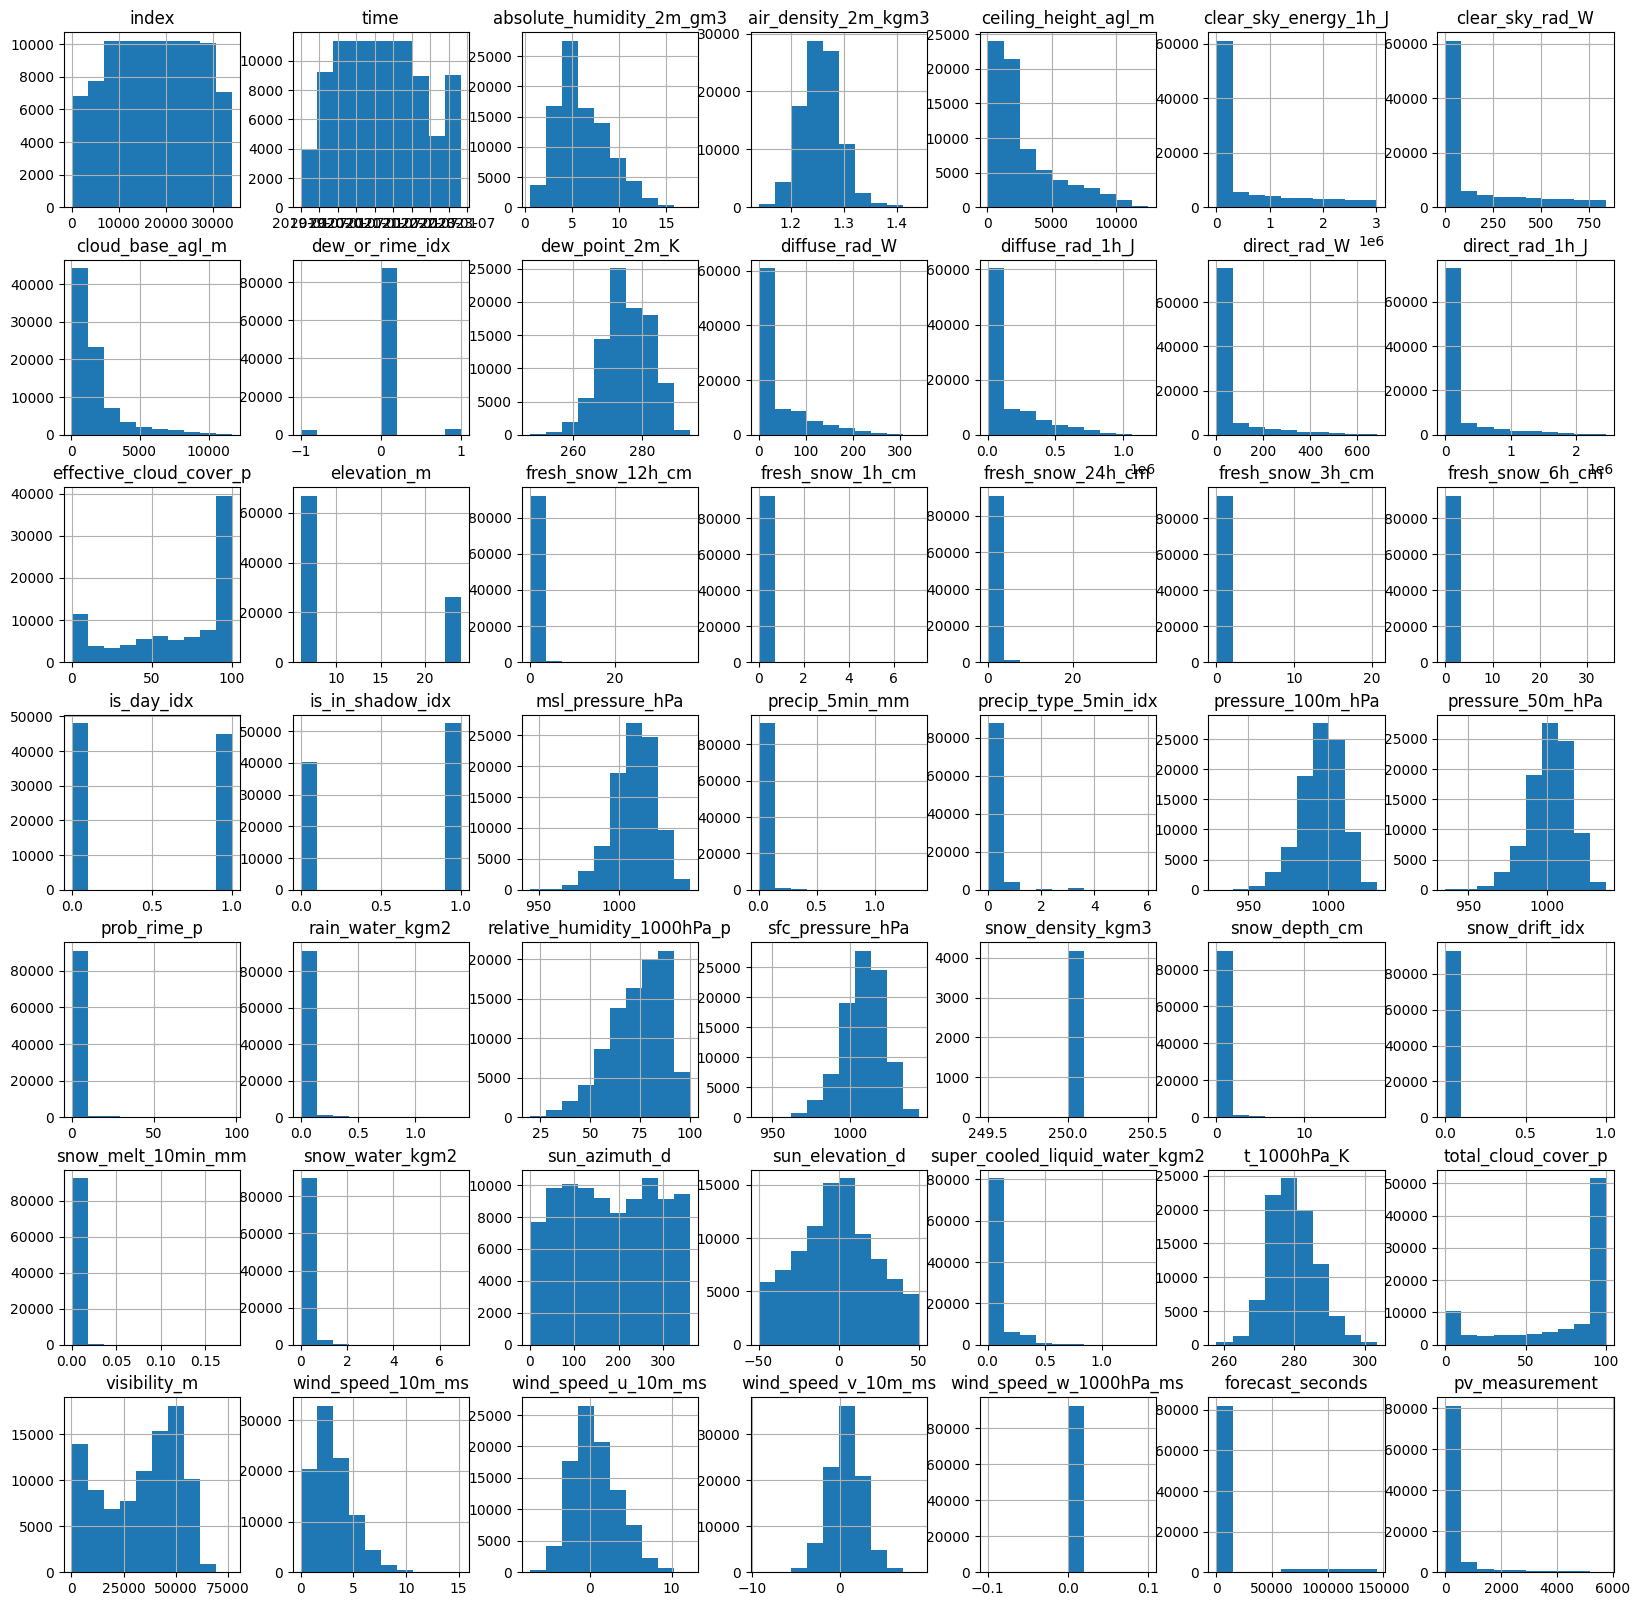

In [11]:
train_data.hist(figsize=(20,20));

1. index
2. time
3. absolute_humidity_2m_gm3
4. air_density_2m_kgm3
5. ceiling_height_agl_m
6. clear_sky_energy_1h_J
7. clear_sky_rad_W
8. cloud_base_agl_m
9. dew_or_rime_idx
10. dew_point_2m_K
11. diffuse_rad_W
12. diffuse_rad_1h_J
13. direct_rad_W
14. direct_rad_1h_J
15. effective_cloud_cover_p
16. elevation_m
17. fresh_snow_12h_cm
18. fresh_snow_1h_cm
19. fresh_snow_24h_cm
20. fresh_snow_3h_cm
21. fresh_snow_6h_cm
22. is_day_idx
23. is_in_shadow_idx
24. msl_pressure_hPa
25. precip_5min_mm
26. precip_type_5min_idx
27. pressure_100m_hPa
28. pressure_50m_hPa
29. prob_rime_p
30. rain_water_kgm2
31. relative_humidity_1000hPa_p
32. sfc_pressure_hPa
33. snow_density_kgm3
34. snow_depth_cm
35. snow_drift_idx
36. snow_melt_10min_mm
37. snow_water_kgm2
38. sun_azimuth_d
39. sun_elevation_d
40. super_cooled_liquid_water_kgm2
41. t_1000hPa_K
42. total_cloud_cover_p
43. visibility_m
44. wind_speed_10m_ms
45. wind_speed_u_10m_ms
46. wind_speed_v_10m_ms
47. wind_speed_w_1000hPa_ms
48. forecast_sec

C:\Users\clar1\AppData\Local\Temp\ipykernel_21632\3528957958.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(train_data.corr(), cmap="PRGn", interpolation="none", vmin=-1, vmax=1)


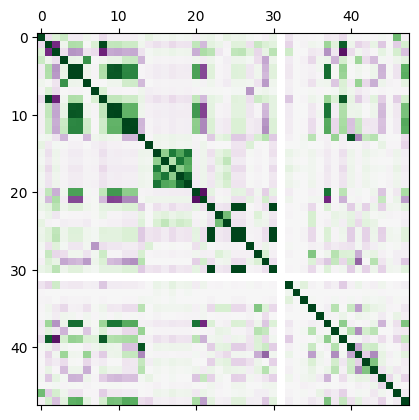

In [12]:
for i, column in enumerate(train_data.columns, 1):
    print(f"{i}. {column}")

plt.matshow(train_data.corr(), cmap="PRGn", interpolation="none", vmin=-1, vmax=1)
plt.show()

# Pycaret regression

Import pycaret

In [5]:
from pycaret.regression import RegressionExperiment
exp = RegressionExperiment()

Setup basic model

In [14]:
exp.setup(train_data, target = 'pv_measurement')

,Description,Value
0,Session id,6925
1,Target,pv_measurement
2,Target type,Regression
3,Original data shape,"(92951, 50)"
4,Transformed data shape,"(92951, 54)"
5,Transformed train set shape,"(65065, 54)"
6,Transformed test set shape,"(27886, 54)"
7,Numeric features,47
8,Date features,1
9,Categorical features,1


Train and compare different models

In [15]:
exp.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,90.4945,62064.7107,248.9950,0.8944,1.7740,2.4307,8.3510
xgboost,Extreme Gradient Boosting,92.7956,65772.5547,256.3196,0.8881,1.6738,3.0934,0.5800
et,Extra Trees Regressor,84.1125,65729.9228,256.2927,0.8881,0.8537,1.6342,9.4600
lightgbm,Light Gradient Boosting Machine,91.4495,66081.5863,256.9569,0.8875,1.4896,3.0710,0.5600
rf,Random Forest Regressor,87.0231,69395.6787,263.2978,0.8819,0.8834,1.3547,32.8560
gbr,Gradient Boosting Regressor,109.7402,82114.1058,286.4103,0.8604,2.0173,3.4749,9.3220
ada,AdaBoost Regressor,162.0015,120444.1732,346.9531,0.7952,2.7133,9.2455,2.8730
dt,Decision Tree Regressor,116.3117,140415.7470,374.2920,0.7619,0.9183,1.3645,0.5940
lr,Linear Regression,316.1365,246172.6122,496.0006,0.5819,3.8795,40.4783,0.8110
br,Bayesian Ridge,316.0551,246245.9312,496.0740,0.5818,3.8793,39.2800,0.3450


With 50% of the features

In [16]:
exp.setup(train_data, target = 'pv_measurement', feature_selection=True, n_features_to_select = 0.5)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7409
[LightGBM] [Info] Number of data points in the train set: 65065, number of used features: 51
[LightGBM] [Info] Start training from score 284.961134


,Description,Value
0,Session id,2756
1,Target,pv_measurement
2,Target type,Regression
3,Original data shape,"(92951, 50)"
4,Transformed data shape,"(92951, 25)"
5,Transformed train set shape,"(65065, 25)"
6,Transformed test set shape,"(27886, 25)"
7,Numeric features,47
8,Date features,1
9,Categorical features,1


In [17]:
exp.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,90.8160,63768.1680,252.3247,0.8906,1.7467,1.8421,6.1170
lightgbm,Light Gradient Boosting Machine,91.6400,67245.7618,259.0786,0.8845,1.4879,1.6526,0.6660
xgboost,Extreme Gradient Boosting,93.1872,67648.0863,259.9027,0.8840,1.6623,1.8974,0.7350
et,Extra Trees Regressor,87.1436,69410.3386,263.2381,0.8809,0.9406,1.3828,5.6290
rf,Random Forest Regressor,87.5257,70866.1472,265.9781,0.8783,0.9346,1.3015,25.3420
gbr,Gradient Boosting Regressor,110.2093,82597.4947,287.0952,0.8583,2.0582,3.0971,7.1290
ada,AdaBoost Regressor,162.7172,121991.5776,349.1539,0.7909,2.7069,5.0312,2.0580
dt,Decision Tree Regressor,117.1535,142098.7160,376.6285,0.7559,0.9766,1.3281,0.7930
lr,Linear Regression,310.6850,307436.1935,553.9806,0.4751,3.6393,10.2055,0.6240
ridge,Ridge Regression,307.4475,308290.0280,554.7378,0.4736,3.6176,9.9559,0.4910


With 25% of the origianl features.

In [18]:
exp.setup(train_data, target = 'pv_measurement', feature_selection=True, n_features_to_select = 0.25)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7413
[LightGBM] [Info] Number of data points in the train set: 65065, number of used features: 51
[LightGBM] [Info] Start training from score 286.656329


,Description,Value
0,Session id,657
1,Target,pv_measurement
2,Target type,Regression
3,Original data shape,"(92951, 50)"
4,Transformed data shape,"(92951, 13)"
5,Transformed train set shape,"(65065, 13)"
6,Transformed test set shape,"(27886, 13)"
7,Numeric features,47
8,Date features,1
9,Categorical features,1


Train and compare different models

In [19]:
exp.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,91.9967,63618.7687,252.1721,0.8911,1.7435,1.7896,4.3330
xgboost,Extreme Gradient Boosting,93.4237,65997.4023,256.7892,0.8870,1.6526,1.8226,0.6530
lightgbm,Light Gradient Boosting Machine,93.6210,68324.9887,261.2939,0.8830,1.4929,1.5969,0.5640
et,Extra Trees Regressor,88.5733,70091.0750,264.6664,0.8800,0.9628,1.4059,3.1660
rf,Random Forest Regressor,88.4575,70580.9851,265.5734,0.8792,0.9576,1.3784,12.2930
gbr,Gradient Boosting Regressor,110.3902,82630.9063,287.3839,0.8586,2.0037,3.0666,4.0450
ada,AdaBoost Regressor,161.8941,122779.3654,350.3175,0.7899,2.7094,5.1184,1.1370
dt,Decision Tree Regressor,116.7621,137864.6869,371.1545,0.7642,0.9886,1.4184,0.6560
knn,K Neighbors Regressor,187.3754,238978.0430,477.2737,0.5892,1.9095,6.0229,0.5740
br,Bayesian Ridge,305.0786,319338.8991,565.0368,0.4536,3.5845,10.4941,0.5190


In [13]:
exp.setup(
    train_data, target = 'pv_measurement', 
    feature_selection=True, 
    n_features_to_select = 0.25,
    normalize=True,
    transformation=True,
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7060
[LightGBM] [Info] Number of data points in the train set: 65065, number of used features: 51
[LightGBM] [Info] Start training from score 284.310400


,Description,Value
0,Session id,3241
1,Target,pv_measurement
2,Target type,Regression
3,Original data shape,"(92951, 50)"
4,Transformed data shape,"(92951, 13)"
5,Transformed train set shape,"(65065, 13)"
6,Transformed test set shape,"(27886, 13)"
7,Numeric features,47
8,Date features,1
9,Categorical features,1


In [14]:
exp.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,91.2038,63998.0482,252.8738,0.8894,1.7362,1.7960,4.9790
xgboost,Extreme Gradient Boosting,93.4314,67829.9980,260.3426,0.8828,1.6397,1.8391,1.3700
lightgbm,Light Gradient Boosting Machine,92.7817,68326.7537,261.2961,0.8819,1.5022,1.5929,1.2720
et,Extra Trees Regressor,87.3817,69480.3971,263.5421,0.8799,0.9603,1.3588,3.8600
rf,Random Forest Regressor,88.1728,71193.1956,266.7554,0.8770,0.9523,1.3359,13.0700
gbr,Gradient Boosting Regressor,110.1715,82958.4794,287.9538,0.8566,2.0508,3.0904,4.5140
ada,AdaBoost Regressor,162.8087,124845.9446,353.2462,0.7843,2.5827,5.6348,2.0940
dt,Decision Tree Regressor,117.3413,143860.5821,379.0965,0.7513,0.9889,1.4560,1.2970
knn,K Neighbors Regressor,154.4079,160621.5719,400.7127,0.7226,1.2225,3.3652,1.5960
lr,Linear Regression,354.0253,378269.0116,614.9460,0.3478,3.7619,18.8521,1.6380


# Pytorch nerual network

# Notes to self

Feature selection can be done with 10, but is better with 25. No need to sort after time, the result is basically the same.